In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [ ]:
num_detection = []
detection_score = []

with open('/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    num_detection = [int(row['num_detections']) for row in reader]
    
    #for row in reader:
    #    tmp_num = int(row['num_detections'])
    #    num_detection.append(tmp_num)
        
        
        #tmp_score = []
        #for score in row['detection_scores']:
        #    print(score)
            #tmp_score.append(float(score))
        #detection_score.append(tmp_score)
            
        
        #print(row['num_detections'])
        
        
#num_detections detection_boxes detection_scores detection_classes

plt.plot(np.arange(len(num_detection)), num_detection)
plt.show()

In [ ]:
boxes_output = []
box_per_frame = []
mean_box_size_per_frame = []
human_box_per_frame = []

with open('/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    # Loop over the rows in the file
    for row in reader :
        # Get the number of detection for a given row
        num_detect = int(row['num_detections'])
        box_per_frame.append(num_detect)
        #print(num_detect)
        
        # Get the detection scores of those detections
        detect_score = row['detection_scores'][1:-1].split()[:num_detect]
        # Convert the string to a float
        detect_score = [float(item) for item in detect_score]
        #print(detect_score)
        
        # Get the classes of those detections
        classes = row['detection_classes'][1:-1].split()[:num_detect]
        # Convert the string to int
        classes = [int(item) for item in classes]
        #print(classes)
        
        # Get the bounding boxes positions
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        # save the box mean size
        mean_size = 0

        bounding_box = row['detection_boxes'][2:-2]
        tmp_values_allboxes = bounding_box.split(']\n [')
        for val in tmp_values_allboxes[:num_detect]:
            ymin.append(float(val.split()[0]))
            xmin.append(float(val.split()[1]))
            ymax.append(float(val.split()[2]))
            xmax.append(float(val.split()[3]))
            mean_size += (float(val.split()[2])-float(val.split()[0]))*(float(val.split()[3])-float(val.split()[1]))

        #print(bounding_box.split(']\n [')[0].split())

        # Normalize the mean size
        mean_size = mean_size / num_detect
        mean_box_size_per_frame.append(mean_size)
        boxes_output.append([detect_score, classes, xmin, ymin, xmax, ymax])
        
#print(boxes_output)

In [2]:
# Method that takes the csv file as input and return the informations about the bounding boxes per frame
def get_raw_boxes_information(csv_filename) :
    # Define the output
    boxes_output = []
    box_per_frame = []

    # Open the file
    with open(csv_filename) as csvfile:
        reader = csv.DictReader(csvfile)
        # Loop over the rows in the file
        for row in reader :
            # Get the number of detection for a given row
            num_detect = int(row['num_detections'])
            box_per_frame.append(num_detect)
            #print(num_detect)

            # Get the detection scores of those detections
            detect_score = row['detection_scores'][1:-1].split()[:num_detect]
            # Convert the string to a float
            detect_score = [float(item) for item in detect_score]
            #print(detect_score)

            # Get the classes of those detections
            classes = row['detection_classes'][1:-1].split()[:num_detect]
            # Convert the string to int
            classes = [int(item) for item in classes]
            #print(classes)

            # Get the bounding boxes positions
            xmin = []
            ymin = []
            xmax = []
            ymax = []
            bounding_box = row['detection_boxes'][2:-2]
            tmp_values_allboxes = bounding_box.split(']\n [')
            for val in tmp_values_allboxes[:num_detect]:
                ymin.append(float(val.split()[0]))
                xmin.append(float(val.split()[1]))
                ymax.append(float(val.split()[2]))
                xmax.append(float(val.split()[3]))

            # append the data
            boxes_output.append([detect_score, classes, xmin, ymin, xmax, ymax])

    
    return boxes_output, box_per_frame
    

In [3]:
# perform non max suppression on boxes to remove double detections in each frame
def non_max_suppression(boxes_info, iou_threshold = 0.8):
    output_boxes = []
    # loop over all frames
    for frame in boxes_info :
        # initialize the list of picked indexes	
        pick = []

        # grab the coordinates of the bounding boxes
        x1 = np.asarray(frame)[2,:]
        y1 = np.asarray(frame)[3,:]
        x2 = np.asarray(frame)[4,:]
        y2 = np.asarray(frame)[5,:]
        
         
        # compute the area of the bounding boxes
        area = (x2 - x1) * (y2 - y1)
        # and sort the bounding by detection score
        idxs = np.argsort(frame[0])
        
        # keep looping while some indices still remain in the index list
        while len(idxs) > 0:
            # grab the last index in the indices list and add the
            # index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            # compute the intersection area
            intersect = (xx2-xx1)*(yy2-yy1)
            # compute the union area
            union = (x2[i]-x1[i])*(y2[i]-y1[i]) - intersect + (x2[idxs[:last]]-x1[idxs[:last]])*(y2[idxs[:last]]-y1[idxs[:last]])
            # compute the iou
            iou = intersect / union
            # delete all indexes from the index list that have an iou greater
            # than the provided overlap threshold
            idxs = np.delete(idxs, np.concatenate(([last],
                   np.where(iou > iou_threshold)[0])))
            
        # return only the bounding boxes that were picked using the
        # integer data type
        #print(pick)
        score = []
        classes = []
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        for i in pick:
            score.append(frame[0][i])
            classes.append(frame[1][i])
            xmin.append(frame[2][i])
            ymin.append(frame[3][i])
            xmax.append(frame[4][i])
            ymax.append(frame[5][i])
        output_boxes.append([score,classes,xmin,ymin,xmax,ymax])
        #output_boxes.append(boxes_info[pick])
        #for box in boxes_info[pick] :
        #    output_boxes.append(box)
    return output_boxes

In [85]:
# Method that returns the number of human boxes per frame for a given threshold over detection confidence
def get_human_boxes_per_frame(boxes_info, detect_threshold = 0.5, size_threshold = 0.0) :
    human_per_frame = []
    # loop over all frames
    for frame in boxes_info :
        # define a mean to zero
        count = 0
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > detect_threshold and frame[1][i]==1:
                # if a size threshold is given check the box is larger
                if size_threshold > 0.:
                    size = (frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i])
                    if size > size_threshold:
                        count = count+1
                else :
                    count = count+1
        human_per_frame.append(count)        
            
    return human_per_frame


# Method that returns the weighted number of human boxes per frame for a given threshold over detection confidence
def get_weighted_human_boxes_per_frame(boxes_info, detect_threshold = 0.5, size_threshold = 0.0) :
    human_per_frame = []

    # loop over all frames
    for frame in boxes_info :
        # define a mean to zero
        count = 0.
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > detect_threshold and frame[1][i]==1:
                # compute the x and y center of the box
                xcenter = np.abs(0.5*(frame[2][i]+frame[4][i])-0.5)
                ycenter = np.abs(0.5*(frame[3][i]+frame[5][i])-0.5)
                radial_dist = np.square(xcenter) + np.square(ycenter)
                weight = 1-2*radial_dist
                # if a size threshold is given check the box is larger
                if size_threshold > 0.:
                    size = (frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i])
                    if size > size_threshold:
                        count = count+weight
                else :
                    count = count+weight
        human_per_frame.append(count)        
            
    return human_per_frame


# Method that returns the mean human boxes size per frame for a given threshold over detection confidence
def get_mean_human_boxes_size_per_frame(boxes_info, detect_threshold = 0.5) :
    mean_box_size = []
    # loop over all frames
    for frame in boxes_info :
        # define a mean to zero
        mean = 0
        count = 0
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > detect_threshold and frame[1][i]==1:
                mean = (frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i])
                count += 1
        if count > 0:
            mean_box_size.append(mean/count)        
            
    return mean_box_size

# Method that computes the histogram of the human boxes sizes
def get_human_boxes_size_hist(boxes_info, detect_threshold = 0.5):
    human_box_size = []
    # loop over all frames
    for frame in boxes_info :
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            # check the score is greather than the threshold and the class is human
            if frame[0][i] > detect_threshold and frame[1][i]==1:
                human_box_size.append((frame[4][i]-frame[2][i])*(frame[5][i]-frame[3][i]))
            
    return human_box_size

# Method that computes the histogram of the detection scores
def get_detection_score_hist(boxes_info):
    detect_score_hist = []
    # loop over all frames
    for frame in boxes_info :
        # loop over all boxes in that frame
        for i in range(len(frame[0])):
            detect_score_hist.append(frame[0][i])
            
    return detect_score_hist

# method that computes the intersection over union of two boxes
def get_iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (xi2-xi1) * (yi2-yi1) 

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area

    return iou

# smoothing curve with rounding 
def curve_smoothing(y, width) :
    yhat = y.copy()
    for i in range(len(y)) :
        low = max(0,int(i-width/2 + 1))
        high = min(len(y)-1, int(i+width/2))
                  
        mean = np.mean(y[low:high])
        yhat[i] = int(round(mean))
        
    return yhat

# method that takes as input a bunch of values and computes the distance
# to the mean for a given width (e.g. 1 second)
def compute_average_distance_to_mean(y, width, mean=0):
    if mean==0:
        round_mean_val = round(np.mean(y))
    else :
        round_mean_val = round(mean)
    output = np.zeros(int(len(y)/width))
    for i in range(int(len(y)/width)):
        output[i] = (np.mean(y[i*width:min((i+1)*width,len(y)-1)]))
        #print(output[i]-round_mean_val)
        
    return (output-round_mean_val)


def gauss(x, mu, sigma):
    return np.exp(-np.square(x-mu)/(2*sigma*sigma))

def logistic(x, alpha):
    return 1./(1+np.exp(-alpha*x))

# method that takes an input CSV with bounding box data and outputs
# a value for each second (a higher value means less likely to be a good frame)
def compute_frame_classification(csv_filename, video_duration = 30, 
                                 size_threshold = 0.005, mean_size_threshold = 0.01,
                                 detect_threshold = 0.7, iou_threshold=0.7):
    # Get the raw boxes from the CSV
    raw_boxes_output, box_per_frame = get_raw_boxes_information(csv_filename)
    # Compute the average number of frame per second
    frame_per_sec = int(len(box_per_frame)/video_duration)
    print('frame per second:', frame_per_sec)
    # Compute non max suppression
    boxes_output = non_max_suppression(raw_boxes_output, iou_threshold = iou_threshold)
    # Compute the number of humans per frame
    humans_per_frame = get_weighted_human_boxes_per_frame(boxes_output, detect_threshold = detect_threshold, size_threshold = size_threshold)
    # Compute the global mean humans per frame (with higher size threshold)
    global_mean = np.mean(get_human_boxes_per_frame(boxes_output, detect_threshold = detect_threshold, size_threshold = mean_size_threshold))
    print(global_mean)
    # Compute the distance
    dist = compute_average_distance_to_mean(humans_per_frame, width = frame_per_sec, mean = global_mean)

    return dist


# method that saves the distance to an output CSV file
def save_frame_classification(distance, output_filename):
    time = np.arange(len(dist))
    output = np.stack((time, dist), axis=1)
    np.savetxt(output_filename, dist, delimiter=",")


In [33]:
#csv_filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_arat30-60.csv'
csv_filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_stage-large_cam_1_30fps_arat_660-680s_NAS.csv'
csv_filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/myRawCSVFile_stage-large_cam_3_30fps_270-300s_res101.csv'
csv_filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/video/stage-large_cam_1_30fps_635-665out.csv'
csv_filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/video/DSC-HX9V_2160-2180out.csv'
# get the raw boxes
raw_boxes_output, box_per_frame = get_raw_boxes_information(csv_filename)

# perform non max suppression
boxes_output = non_max_suppression(raw_boxes_output, iou_threshold = 0.7)



mean humans per frame:  9.364392678868553


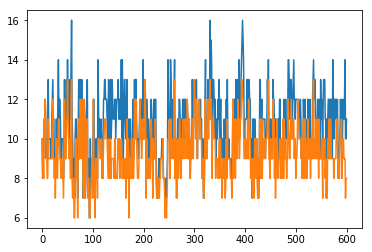

In [37]:
# Display the number of detected human per frame (with and without non max suppression)
detect_threshold = 0.7
raw_humans_per_frame = get_human_boxes_per_frame(raw_boxes_output, detect_threshold = detect_threshold)
humans_per_frame = get_human_boxes_per_frame(boxes_output, detect_threshold = detect_threshold)

print('mean humans per frame: ', np.mean(humans_per_frame))

plt.plot(np.arange(len(humans_per_frame)), raw_humans_per_frame, humans_per_frame)
plt.show()

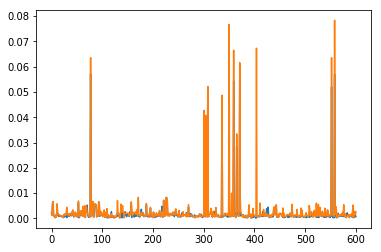

In [38]:
# Display the mean human box size per frame (with and without non max suppression)
raw_mean_human_size = get_mean_human_boxes_size_per_frame(raw_boxes_output, detect_threshold = detect_threshold)
mean_human_size = get_mean_human_boxes_size_per_frame(boxes_output, detect_threshold = detect_threshold)
plt.plot(np.arange(len(mean_human_size)), raw_mean_human_size, mean_human_size)
plt.show()

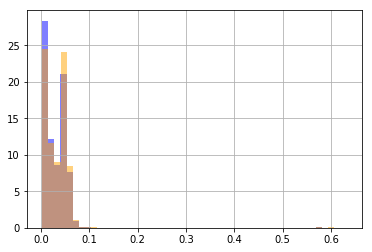

In [39]:
raw_human_box_hist = get_human_boxes_size_hist(raw_boxes_output, detect_threshold = detect_threshold)
human_box_hist = get_human_boxes_size_hist(boxes_output, detect_threshold = detect_threshold)
# the histogram of the data
plt.hist(raw_human_box_hist, 50, normed=1, facecolor='blue', alpha=0.5)
plt.hist(human_box_hist, 50, normed=1, facecolor='orange', alpha=0.5)

# add a 'best fit' line
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

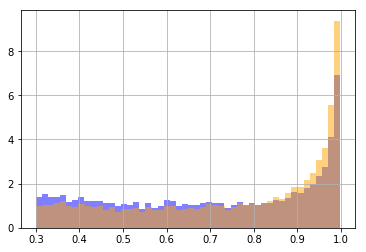

In [40]:
raw_scores_hist = get_detection_score_hist(raw_boxes_output)
score_hist = get_detection_score_hist(boxes_output)
# the histogram of the data
plt.hist(raw_scores_hist, 50, normed=1, facecolor='blue', alpha=0.5)
plt.hist(score_hist, 50, normed=1, facecolor='orange', alpha=0.5)

# add a 'best fit' line
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

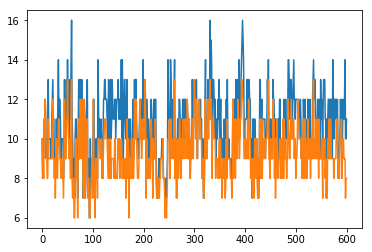

8.259567387687188


In [42]:
# 
detect_threshold = 0.7
size_threshold = 0.002
raw_humans_per_frame = get_human_boxes_per_frame(raw_boxes_output, detect_threshold = detect_threshold, size_threshold = size_threshold)
humans_per_frame = get_human_boxes_per_frame(boxes_output, detect_threshold = detect_threshold, size_threshold = size_threshold)

plt.plot(np.arange(len(humans_per_frame)), raw_humans_per_frame, humans_per_frame)
plt.show()

global_mean = get_human_boxes_per_frame(boxes_output, detect_threshold = 0.7, size_threshold = 0.01)
print(np.mean(global_mean))

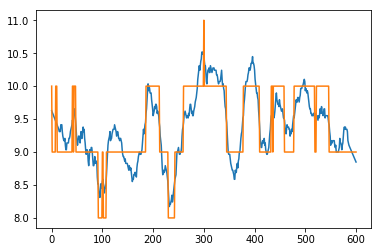

In [43]:
# Perform curve smoothing on the humans per frame data
width = 29
poly_order = 1
savgol_humans_per_frame = savgol_filter(humans_per_frame, width, poly_order)
handmade_smoothing = curve_smoothing(humans_per_frame, width = width)
#handmade_smoothing = curve_smoothing(handmade_smoothing, width = width)
plt.plot(np.arange(len(savgol_humans_per_frame)), savgol_humans_per_frame, handmade_smoothing)
plt.show()

In [12]:
np.mean(humans_per_frame)

4.102135561745589

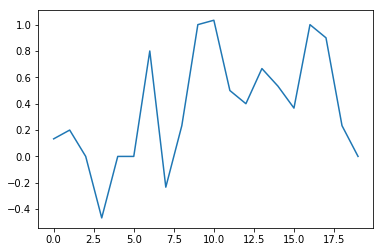

In [44]:
dist = compute_average_distance_to_mean(handmade_smoothing, 30)
plt.plot(np.arange(len(dist)), dist)
plt.show()

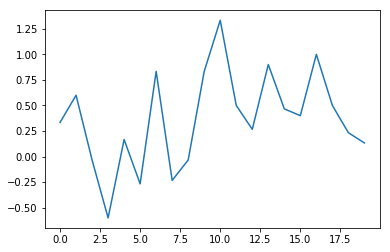

In [45]:
dist = compute_average_distance_to_mean(humans_per_frame, 30)
plt.plot(np.arange(len(dist)), dist)
plt.show()

frame per second: 30
5.658901830282862


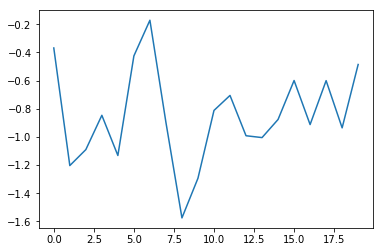

In [86]:
filename = '/home/vince/Documents/Freelance/Sweesp/source/frameClassification/video/DSC-HX9V_2160-2180out.csv'
dist = compute_frame_classification(csv_filename = filename, video_duration = 20, size_threshold = 0.02, 
                                    mean_size_threshold = 0.02, detect_threshold = 0.7, iou_threshold=0.7)


plt.plot(np.arange(len(dist)), dist)
plt.show()